In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
mpl.rcParams['figure.figsize'] = (12,8)

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

## Import Data

In [6]:
# parent_path = '/kaggle/input/titanic/'
parent_path = ''
data_ = pd.read_csv(parent_path+'train.csv').set_index('PassengerId')

df_test = pd.read_csv(parent_path+'test.csv').set_index('PassengerId')
data_.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
data_.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(data_.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       33

## Data analysis and feature engineering

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X = data_
X['Age'] = X['Age'].fillna(X['Age'].mean())
X['Sex'] = X['Sex'].replace({'male': 0, 'female': 1})
X['FamilySize'] = X['SibSp'] + X['Parch']
X['IsAlone'] = X['FamilySize'].apply(lambda x: 1 if x==0 else 0)
X['Embarked'] = le.fit_transform(X['Embarked'])

X_test = df_test
X_test['Age']= X_test['Age'].fillna(X_test['Age'].mean())
X_test['Fare'] = X_test['Fare'].fillna(X_test['Fare'].mean())
X_test['Sex'] = X_test['Sex'].replace({'male': 0, 'female': 1})
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch']
X_test['IsAlone'] = X_test['FamilySize'].apply(lambda x: 1 if x==0 else 0)
X_test['Embarked'] = le.fit_transform(X_test['Embarked'])


# Extract the title from the 'Name' column and store it in a new column called 'Title'
X['Title'] = X['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Replace rare titles with more common ones
X['Title'] = X['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
X['Title'] = X['Title'].replace('Mlle', 'Miss')
X['Title'] = X['Title'].replace('Ms', 'Miss')
X['Title'] = X['Title'].replace('Mme', 'Mrs')

# Map each title to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
X['Title'] = X['Title'].map(title_mapping)


# Extract the title from the 'Name' column and store it in a new column called 'Title'
X_test['Title'] = X_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Replace rare titles with more common ones
X_test['Title'] = X_test['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
X_test['Title'] = X_test['Title'].replace('Mlle', 'Miss')
X_test['Title'] = X_test['Title'].replace('Ms', 'Miss')
X_test['Title'] = X_test['Title'].replace('Mme', 'Mrs')

# Map each title to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
X_test['Title'] = X_test['Title'].map(title_mapping)

In [6]:
# Create a new column called 'AgeGroup' based on the passenger's age
bins = [0, 12, 18, 25, 40, 60, 100]
labels = ['Child', 'Teenager', 'Young Adult', 'Adult', 'Middle Aged', 'Senior']
age_mapping = {'Child': 1, 'Teenager': 2, 'Young Adult': 3, 'Adult': 4, 'Middle Aged': 5, 'Senior': 6}

X['AgeGroup'] = pd.cut(X['Age'], bins=bins, labels=labels, include_lowest=True)
X['AgeGroup'] = X['AgeGroup'].map(age_mapping)

X_test['AgeGroup'] = pd.cut(X_test['Age'], bins=bins, labels=labels, include_lowest=True)
X_test['AgeGroup'] = X_test['AgeGroup'].map(age_mapping)

In [7]:
print(X.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    int64   
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Ticket      891 non-null    object  
 8   Fare        891 non-null    float64 
 9   Cabin       204 non-null    object  
 10  Embarked    891 non-null    int64   
 11  FamilySize  891 non-null    int64   
 12  IsAlone     891 non-null    int64   
 13  Title       891 non-null    int64   
 14  AgeGroup    891 non-null    category
dtypes: category(1), float64(2), int64(9), object(3)
memory usage: 105.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 14 c

In [8]:
X.AgeGroup

PassengerId
1      3
2      4
3      4
4      4
5      4
      ..
887    4
888    3
889    4
890    4
891    4
Name: AgeGroup, Length: 891, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [9]:
X = data_.drop(['Name','Ticket','Cabin','Survived'], axis=1)
X_test = df_test.drop(['Name','Ticket','Cabin'], axis=1)
Y = data_['Survived']
# Y_test = df_test['Survived']

In [10]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'FamilySize', 'IsAlone', 'Title', 'AgeGroup'],
      dtype='object')

In [11]:
X_test.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'FamilySize', 'IsAlone', 'Title', 'AgeGroup'],
      dtype='object')

In [12]:
X['Sex'] = X['Sex'].replace({'male': 0, 'female': 1})
X_test['Sex'] = X_test['Sex'].replace({'male': 0, 'female': 1})

In [13]:
le = LabelEncoder()
X['Embarked'] = le.fit_transform(X['Embarked'])
X_test['Embarked'] = le.fit_transform(X_test['Embarked'])

In [14]:
X.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,1.538721,0.904602,0.602694,1.728395
std,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.794231,1.613459,0.489615,1.030039
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,0.000000,0.000000,1.000000
50%,3.000000,0.000000,29.699118,0.000000,0.000000,14.454200,2.000000,0.000000,1.000000,1.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000,1.000000,2.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000,10.000000,1.000000,5.000000


In [15]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,AgeGroup
PassengerId,,,,,,,,,,,
1,3,0,22.0,1,0,7.2500,2,1,0,1,3
2,1,1,38.0,1,0,71.2833,0,1,0,3,4
3,3,1,26.0,0,0,7.9250,2,0,1,2,4
4,1,1,35.0,1,0,53.1000,2,1,0,3,4
5,3,0,35.0,0,0,8.0500,2,0,1,1,4


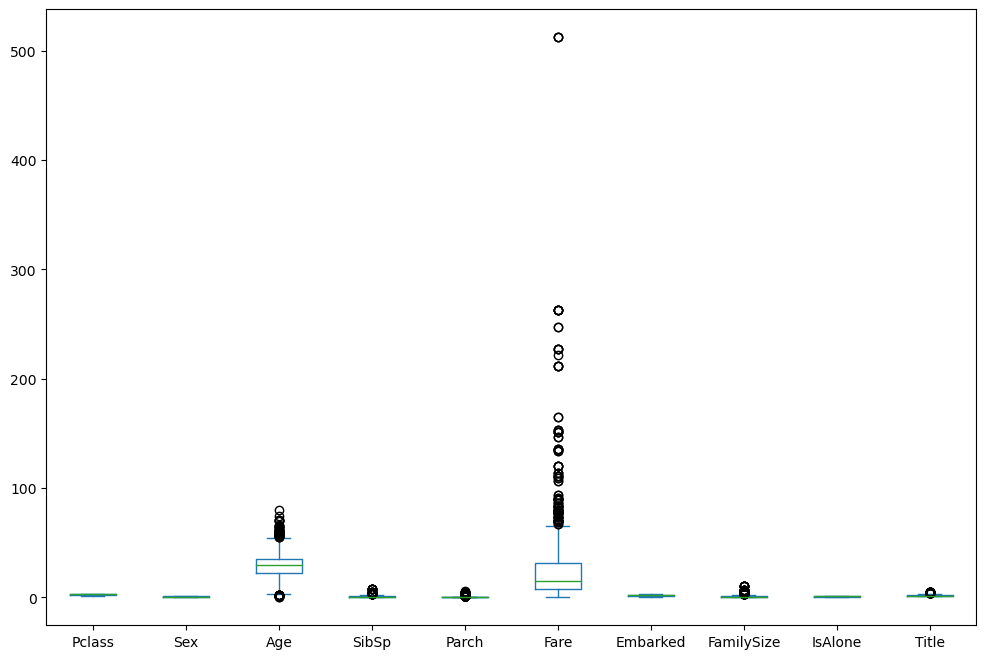

In [16]:
X.plot(kind='box')
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X[['Age', 'Fare']] = scaler.fit_transform(X[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.fit_transform(X_test[['Age', 'Fare']])

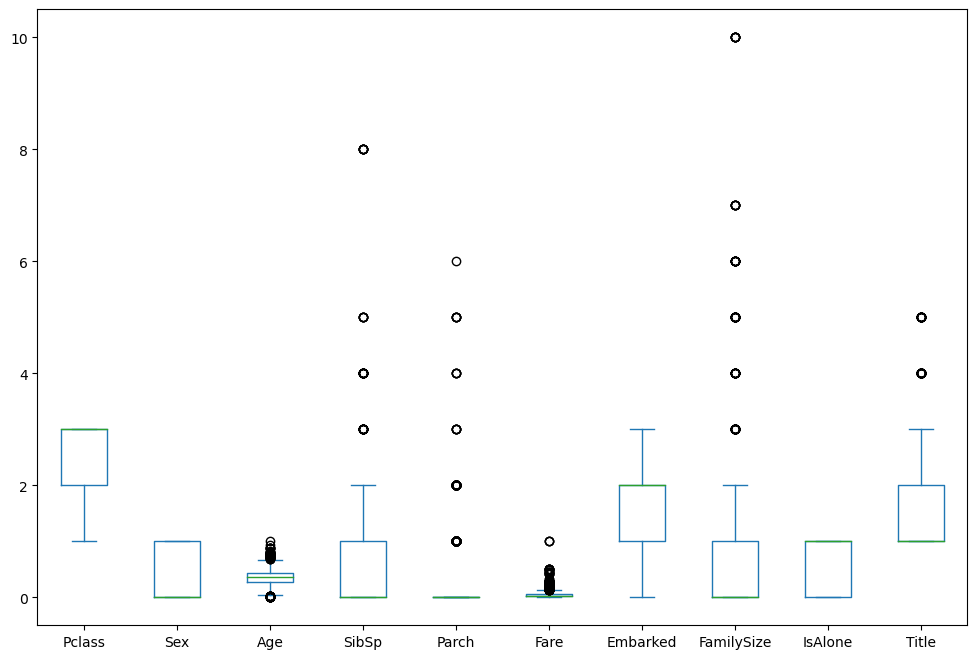

              Pclass       Sex       Age     SibSp     Parch      Fare  \
Pclass      1.000000 -0.131900 -0.331339  0.083081  0.018443 -0.549500   
Sex        -0.131900  1.000000 -0.084153  0.114631  0.245489  0.182333   
Age        -0.331339 -0.084153  1.000000 -0.232625 -0.179191  0.091566   
SibSp       0.083081  0.114631 -0.232625  1.000000  0.414838  0.159651   
Parch       0.018443  0.245489 -0.179191  0.414838  1.000000  0.216225   
Fare       -0.549500  0.182333  0.091566  0.159651  0.216225  1.000000   
Embarked    0.157112 -0.104057 -0.022239  0.066654  0.038322 -0.221226   
FamilySize  0.065997  0.200988 -0.248512  0.890712  0.783111  0.217138   
IsAlone     0.135207 -0.303646  0.179775 -0.584471 -0.583398 -0.271832   
Title      -0.173929  0.502713 -0.097454  0.269623  0.315784  0.136310   

            Embarked  FamilySize   IsAlone     Title  
Pclass      0.157112    0.065997  0.135207 -0.173929  
Sex        -0.104057    0.200988 -0.303646  0.502713  
Age        -0.022239

In [18]:
X.plot(kind='box')
plt.show()

corr_matrix = X.corr()
# display the correlation matrix
print(corr_matrix)

## Feature selection

In [19]:
min_features_to_select = 2  # Minimum number of features to consider
clf = LogisticRegression()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, Y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 10


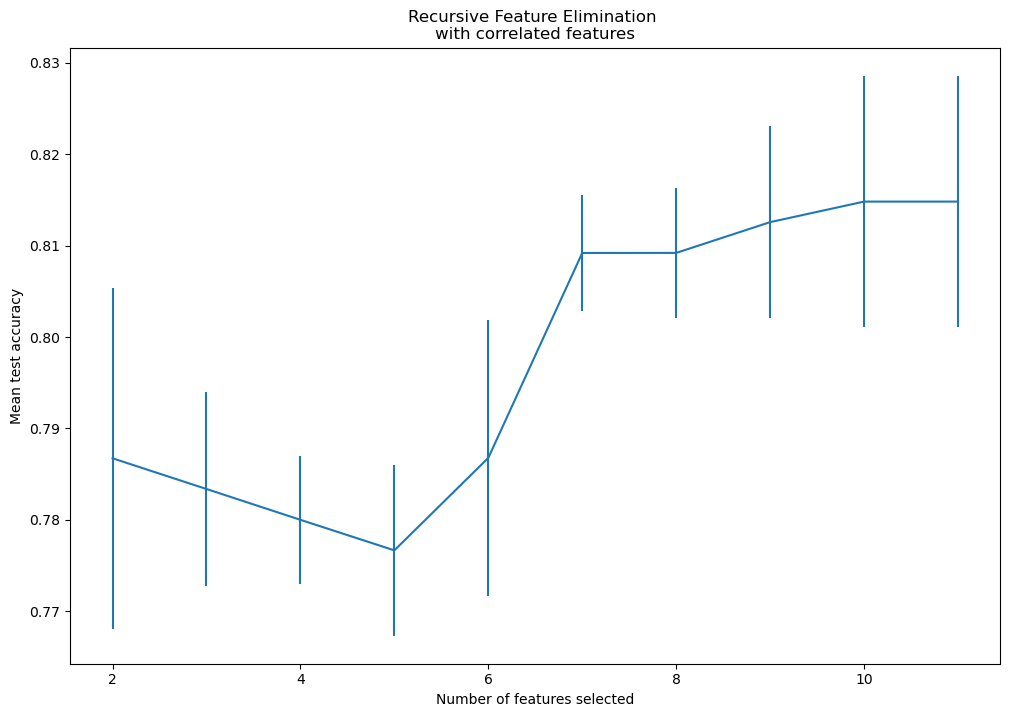

In [20]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [21]:
Selector = SelectKBest(f_classif, k=rfecv.n_features_)
X_new=Selector.fit_transform(X, Y)
selected_features = Selector.get_support()
print(selected_features)

[ True  True  True  True  True  True  True False  True  True  True]


In [22]:
X_test_selected = X_test.loc[:, selected_features]
X_test_selected.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.363636,0.396975,0.447368,0.392344,0.069540,1.401914,0.605263,1.741627
std,0.841838,0.481622,0.166617,0.896760,0.981429,0.108993,0.854496,0.489380,1.006091
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,0.301068,0.000000,0.000000,0.015412,1.000000,0.000000,1.000000
50%,3.000000,0.000000,0.396975,0.000000,0.000000,0.028213,2.000000,1.000000,1.000000
75%,3.000000,1.000000,0.469207,1.000000,0.000000,0.061484,2.000000,1.000000,2.000000
max,3.000000,1.000000,1.000000,8.000000,9.000000,1.000000,2.000000,1.000000,5.000000


## Cross Validation

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

X_train=X_new
X_test_selected = X_test.loc[:, selected_features]



param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']}
cv = StratifiedShuffleSplit(n_splits=4, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train,Y)
print(grid.best_params_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


## Train the Data

In [24]:

svm = SVC(kernel='rbf', C=1,gamma=0.1)
svm.fit(X_train, Y)
y_pred = svm.predict(X_test_selected)

# plot_confusion_matrix(svm, X_test_selected, Y_test)
# plt.show()
# report = classification_report(Y_test, y_pred)
# print(report)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


## Output creation

In [25]:
model_submission = pd.DataFrame({
    'PassengerId': df_test.index,
    'Survived': y_pred
})
model_submission.head(10)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [26]:
model_submission.to_csv('submission.csv',index = False)